<a href="https://colab.research.google.com/github/chihway/cosmology_on_beach_2022/blob/main/Tutorial3_cosmology_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Explore MCMC chains**

Time: 20 min

In this tutorial we will learn how to plot and interpret MCMC chains. 

We will learn to:
* Plot different number of parameters from the chains, print out their 1-sigma constraints
* Compare chains from different experiment and understand what the difference between them mean and don't mean

We will be making the plots using the software package [chainconsumer](https://github.com/Samreay/ChainConsumer).

In [1]:
import numpy as np
import pylab as mplot
%pylab inline
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
# we will need to install chainconsumer to plot the chains
!pip install chainconsumer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 43 kB 486 kB/s 
  Created wheel for chainconsumer: filename=ChainConsumer-0.34.0-py3-none-any.whl size=42778 sha256=33a7e003690be7958ece4bfca7d4073594a7cf186b4eea069f6eef44aaeccbf4
  Stored in directory: /root/.cache/pip/wheels/2d/e5/6c/c9b963aa8bafc25991c7ce2902ca81be7256746be0349137cf
Successfully built chainconsumer


In [3]:
from chainconsumer import ChainConsumer

We will be using the DES-SV and KiDS-450 chains from [this paper](https://arxiv.org/abs/1808.07335). The paper first tries to reproduce the cosmic shear results from the [DES-SV paper](https://arxiv.org/abs/1507.05552) and the [KiDS-450 paper](https://arxiv.org/abs/1601.05786). It then tries to unify the various analysis choices and compare them again. Let's again download the data.

In [4]:
!rm -rf data_3
!curl -O https://portal.nersc.gov/cfs/lsst/chihway/data_3.tar.gz
!tar -xvzf data_3.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 43.1M  100 43.1M    0     0  24.7M      0  0:00:01  0:00:01 --:--:-- 24.7M
._data_3
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
data_3/
data_3/._mcmc_des_matched2_covg.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attributes'
data_3/mcmc_des_matched2_covg.txt
data_3/._kids450dir_8.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attributes'
data_3/kids450dir_8.txt
data_3/._mcmc_kids_matched2_covg.txt
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attrs'
tar: Ignoring unknown extended header keyword 'LIBARCHIVE.xattr.com.dropbox.attri

### First let's plot the chains from the paper directly

In [5]:
def weighted_percentile(data, percents, weights=None):

    if weights is None:
        return np.percentile(data, percents)
    ind = np.argsort(data)
    d = data[ind]
    w = weights[ind]
    p = 1.*w.cumsum()/w.sum()*100
    y = np.interp(percents, p, d)
    return y

def get_s8(omegam, sigma8):
    return sigma8*np.sqrt(omegam/0.3)
  
def constraints(s8, w):
    low = weighted_percentile(s8, 16, weights=w)
    high = weighted_percentile(s8, 84, weights=w)
    mean = np.average(s8, weights=w)
        
    print("$%.4f_{%.4f}^{%.4f}$" % (mean, mean-low, high-mean))
    return mean, mean-low, high-mean

In [6]:
kids_paper = 'data_3/kids450dir'
des_paper = 'data_3/dessv_chain_reduced_v2.txt'

In [7]:
data_params = []
weights = []
file_list = [des_paper, kids_paper]

Om = np.array([])
s8 = np.array([])
ww = np.array([])

data = np.loadtxt(file_list[0])
os.system("cat "+file_list[0]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,14])
data_params.append([data[-nsample:,0], data[-nsample:,3]*(data[-nsample:,0]/0.3)**0.5]) #12

for i in range(8):
    data = np.loadtxt(file_list[1]+'_'+str(i+1)+'.txt')
    N = len(data)
    Om = np.concatenate((Om, data[int(N*0.3):,10]), axis=0)
    s8 = np.concatenate((s8, data[int(N*0.3):,14]), axis=0)
    ww = np.concatenate((ww, data[int(N*0.3):,0]), axis=0)
data_params.append([Om, get_s8(Om, s8)])
weights.append(ww)

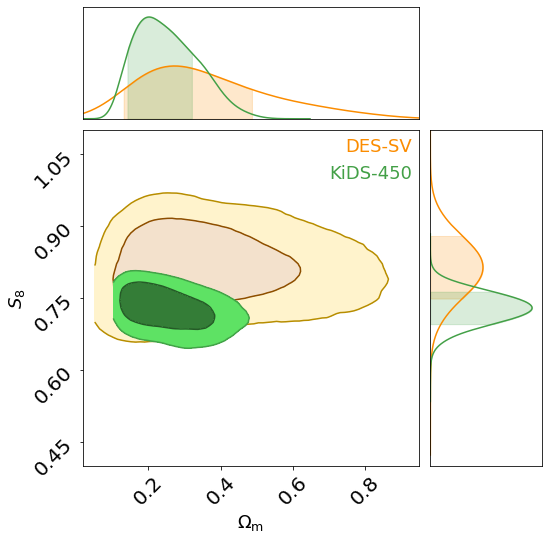

In [8]:
c = ChainConsumer()
c.add_chain(data_params[0], weights=weights[0], parameters=[r"$\Omega_{\rm m}$", r"$S_{8}$"], name='DES-SV')
c.add_chain(data_params[1], weights=weights[1], name='KiDS-450')

c.configure(colors=['orange','g'], label_font_size=18, contour_label_font_size=20, 
            tick_font_size=20, linewidths=[1.5,1.5,1.5,1.5], sigma2d=False, shade=True, 
            kde=1.5, shade_alpha=[0.2,1,0.2,0.7], bar_shade=True, sigmas=[0,1,2])
fig = c.plotter.plot(extents=[(0.02,0.95),(0.4,1.1)])
fig.set_size_inches(4.5 + fig.get_size_inches()) 


We can quickly look at the numerical constraints.

In [17]:
c.analysis.get_summary()

[{'$\\Omega_{\\rm m}$': [0.14430896917824795,
   0.22273322384304944,
   0.35574536986437943],
  '$S_{8}$': [0.7759566439529038, 0.8426068946527137, 0.911461418221621]},
 {'$\\Omega_{\\rm m}$': [0.23807986294553218,
   0.3313719108680151,
   0.4153116046067057],
  '$S_{8}$': [0.7014480613386982, 0.7579935693931983, 0.8092945530918848]}]

### Next let's plot the "unified" chains

In [9]:
kids2_g = 'data_3/mcmc_kids_matched2_covg.txt'
des2_g = 'data_3/mcmc_des_matched2_covg.txt'


In [10]:
data_params = []
weights = []
file_list = [des2_g, kids2_g]

data = np.loadtxt(file_list[0])
os.system("cat "+file_list[0]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,-1])
data_params.append([data[-nsample:,13], data[-nsample:,12]*(data[-nsample:,13]/0.3)**0.5]) #12

data = np.loadtxt(file_list[1])
os.system("cat "+file_list[1]+" | tail -3 | head -1 | sed s/'='/' '/|awk '{print $2}'>nsample")
nsample = int(np.loadtxt('nsample'))
weights.append(data[-nsample:,-1])
data_params.append([data[-nsample:,15], data[-nsample:,14]*(data[-nsample:,15]/0.3)**0.5]) #12


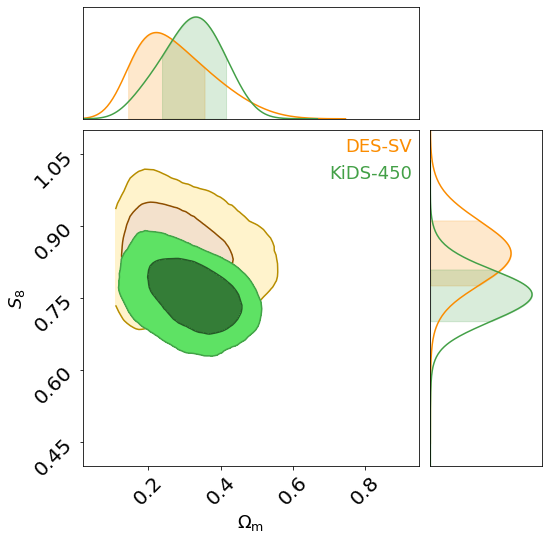

In [11]:
c = ChainConsumer()
c.add_chain(data_params[0], weights=weights[0], parameters=[r"$\Omega_{\rm m}$", r"$S_{8}$"], name='DES-SV')
c.add_chain(data_params[1], weights=weights[1], name='KiDS-450')

c.configure(colors=['orange','g'], label_font_size=18, contour_label_font_size=20, 
            tick_font_size=20, linewidths=[1.5,1.5,1.5,1.5], sigma2d=False, shade=True, 
            kde=1.5, shade_alpha=[0.2,1,0.2,0.7], bar_shade=True, sigmas=[0,1,2])
fig = c.plotter.plot(extents=[(0.02,0.95),(0.4,1.1)])
fig.set_size_inches(4.5 + fig.get_size_inches()) 


In [11]:
c.analysis.get_summary()